In [1]:
import os
import mne
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
#from torch.utils.tensorboard import SummaryWriter

from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from mne.time_frequency import tfr_morlet
from mne import create_info, EpochsArray
from mne.channels import make_dig_montage
from mne.preprocessing import ICA


In [3]:
import subprocess
import gc
import meegkit.asr as asr


In [25]:
import os
import glob
def dir_cleaner(edf_buffer:str, image_buffer:str):
    image_patter_dir = os.path.join(image_buffer, '*.png')
    edf_pattern_dir = os.path.join(edf_buffer, ".edf")
    
    img_files_glob = glob.glob(image_patter_dir)
    efd_files_glob = glob.glob(edf_pattern_dir)

    for file_path in img_files_glob:
        try:
            os.remove(file_path)
            #print(f"deleted {file_path}")
        except Exception as e:
            print(e)
            print(f" error deleting image {file_path}")
            return False
    for file_path in efd_files_glob:
        try:
            os.remove(file_path)
        except Exception as e:
            print(e)
            print(f"error deleting edf {file_path}")
            return False

    return True



In [79]:
dir_cleaner("edf_buffer", "image_buffer")

True

In [5]:
def plot_figs(path, target_path):
    sfreq = 250
    raw = mne.io.read_raw_edf(path, preload=True)
    train_idx = np.arange(0, 30*sfreq, dtype=int)
    gmw = MorseWavelet(gamma=2, beta=1)
    asr_instance = asr.ASR(method='euclid')
    channels = raw.ch_names
    data = raw._data
    asr_data, _ =  asr_instance.fit(data[:, train_idx])

    dict_eeg = {channels[i]: asr_data[i] for i in range(19)}
    

    i=0
    for channel_name , channel_data in dict_eeg.items():
        Wxh, *_ = ghostipy.spectral.cwt(channel_data, wavelet=gmw, voices_per_octave=10)
        #plt.figure(figsize=(8,6))
        plt.imshow(np.abs(Wxh), aspect='auto', cmap='turbo')
        plt.axis('off')
        image_file_name = channel_name+".png"
        image_path = os.path.join(target_path, image_file_name)
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0, format='png')
        print(plt.gcf().get_size_inches())
        plt.close()
        i+=1
        subprocess.run(['sync'])
        gc.collect()
    gc.collect()
    plt.close('all')

    print(dict_eeg, asr_data)    
    return True

In [6]:
plot_figs("h01.edf", "image_buffer")

Extracting EDF parameters from /home/dheeraj/Desktop/projects/scizo_frontend/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
[6.4 4.8]
{'Fp2': array([2.50000000e-09, 2.50000000e-09, 2.50000000e-09, ...,
       1.37864620e-06, 1.37864620e-06, 3.51931806e-06]), 'F8': array([ 2.50000000e-09,  2.50000000e-09,  2.50000000e-09, ...,
        7.67025666e-07, -7.62025666e-07, -3.03310266e-07]), 'T4': array([ 2.50000000e-09,  2.50000000e-09,  2.50000000e-09, ...,
       -1.83236160e-06, -1.52655133e-06,  7.67025666e-07]), 'T6': array([ 2.50000000e-09,  2.50000000e-09,  2.50000000e-09, ...,
       -4.56215400e-07, -1.50405133e-07, -7.62025666e-07]), 'O2': array([ 2.50000000e-09,  2.50000000e-09,  2.50000000e-09, ...,
 

True

In [4]:
import os
from PIL import Image
from torchvision import transforms

In [40]:
def image_transform(image_folder):

    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    for image_file in image_files:
    
        input_path = os.path.join(image_folder, image_file)
        image = Image.open(input_path)

        if image.mode == 'RGBA':
            image = image.convert('RGB')
        

        transformed_image = preprocess(image)

        pil_tranformed_image = transforms.ToPILImage()(transformed_image)

        pil_tranformed_image.save(input_path)
    
    print("transformation to RGB completed")

    return True

    

In [41]:
image_transform("image_buffer")

transformation to RGB completed


True

In [42]:
# image_folder = "image_buffer"
# image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
# print(image_files)

# for image_file in image_files:
#     input_path = os.path.join(image_folder, image_file)
#     print(input_path)

In [16]:
image_transform("image_buffer")

transformation to RGB completed


True

In [43]:
test_image = "image_buffer/P3.png"
test_image_op = Image.open(test_image)
test_image_op.size, test_image_op.mode

((224, 224), 'RGB')

In [2]:
class resnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        self.convolutional_layers = nn.Sequential(resnet.conv1,
                                   resnet.bn1,
                                   resnet.relu,
                                   resnet.maxpool,
                                   resnet.layer1,
                                   resnet.layer2,
                                   resnet.layer3,
                                   resnet.layer4)

        # # Add back the batch norm layer that we removed
        self.avgpool = resnet.avgpool # Global Average pooling layer

        # # # Custom fully connect layer
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.convolutional_layers(x)
    
    def forward(self, images):        
        # Convolutional layers of resnet18
        x = self.convolutional_layers(images) 
               
        # # The layers after the Conv you used the hook on
        h = x.register_hook(self.activations_hook)
        
        # Global average pooling layer from resnet18
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        logits = self.fc(x)
        
        output = F.sigmoid(logits)
        return output

In [31]:
device.type

'cpu'

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet(num_classes=1).to(device)
model_num = 20
checkpoint_path = ""
checkpoint = torch.load(f'resnet-finetune-adam-epoch_{model_num}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Using cache found in /home/dheeraj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [46]:
print(img_array)

[[[115.  85. 232.]
  [121. 105.  19.]
  [125. 117.  45.]
  ...
  [134. 150. 103.]
  [136. 170. 133.]
  [130. 134.  75.]]

 [[115.  87. 236.]
  [123. 109.  25.]
  [127. 123.  53.]
  ...
  [134. 154. 111.]
  [138. 174. 141.]
  [130. 138.  81.]]

 [[115.  87. 236.]
  [123. 109.  29.]
  [127. 123.  57.]
  ...
  [134. 158. 115.]
  [138. 180. 147.]
  [132. 142.  89.]]

 ...

 [[ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  ...
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]]

 [[ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  ...
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]]

 [[ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  ...
  [ 97.  37. 119.]
  [ 97.  37. 119.]
  [ 97.  37. 119.]]]


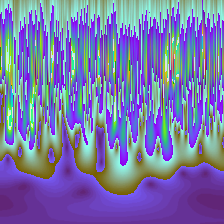

In [51]:
img

In [53]:
test_image= "image_buffer/C4.png"
img = Image.open(test_image)
denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
# img_array = np.array(img, dtype=np.float64)/255.0
# denorm_image = img_array * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
# denorm_image_tensor = torch.from_numpy(denorm_image)
denorm_image = denormalize(np.array(img)/255.0).clip(0,1)
denorm_image_tensor = torch.from_numpy(denorm_image).permute(2, 0, 1)
print(denorm_image_tensor)

TypeError: img should be Tensor Image. Got <class 'numpy.ndarray'>

In [37]:
denorm_image

array([[[ 58. ,  43. , 116.5],
        [ 61. ,  53. ,  10. ],
        [ 63. ,  59. ,  23. ],
        ...,
        [ 67.5,  75.5,  52. ],
        [ 68.5,  85.5,  67. ],
        [ 65.5,  67.5,  38. ]],

       [[ 58. ,  44. , 118.5],
        [ 62. ,  55. ,  13. ],
        [ 64. ,  62. ,  27. ],
        ...,
        [ 67.5,  77.5,  56. ],
        [ 69.5,  87.5,  71. ],
        [ 65.5,  69.5,  41. ]],

       [[ 58. ,  44. , 118.5],
        [ 62. ,  55. ,  15. ],
        [ 64. ,  62. ,  29. ],
        ...,
        [ 67.5,  79.5,  58. ],
        [ 69.5,  90.5,  74. ],
        [ 66.5,  71.5,  45. ]],

       ...,

       [[ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        ...,
        [ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ]],

       [[ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        ...,
        [ 49. ,  19. ,  60. ],
        [ 49. ,  19. ,  60. ],
        [ 49. ,

In [57]:
test_image= "image_buffer/O2.png"
img = Image.open(test_image)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = img.convert('RGB')
img = preprocess(img)
denorm_image = img.permute(1, 2, 0) * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
print(denorm_image/2)

tensor([[[0.2255, 0.1667, 0.4549],
         [0.2373, 0.2059, 0.0373],
         [0.2451, 0.2294, 0.0882],
         ...,
         [0.2627, 0.2941, 0.2020],
         [0.2667, 0.3333, 0.2608],
         [0.2549, 0.2627, 0.1471]],

        [[0.2255, 0.1706, 0.4627],
         [0.2412, 0.2137, 0.0490],
         [0.2490, 0.2412, 0.1039],
         ...,
         [0.2627, 0.3020, 0.2176],
         [0.2706, 0.3412, 0.2765],
         [0.2549, 0.2706, 0.1588]],

        [[0.2255, 0.1706, 0.4627],
         [0.2412, 0.2137, 0.0569],
         [0.2490, 0.2412, 0.1118],
         ...,
         [0.2627, 0.3098, 0.2255],
         [0.2706, 0.3529, 0.2882],
         [0.2588, 0.2784, 0.1745]],

        ...,

        [[0.1902, 0.0725, 0.2333],
         [0.1902, 0.0725, 0.2333],
         [0.1902, 0.0725, 0.2333],
         ...,
         [0.1902, 0.0725, 0.2333],
         [0.1902, 0.0725, 0.2333],
         [0.1902, 0.0725, 0.2333]],

        [[0.1902, 0.0725, 0.2333],
         [0.1902, 0.0725, 0.2333],
         [0.

In [59]:
from PIL import Image
import numpy as np
import torch

# Load the preprocessed image using PIL
test_image = "image_buffer/O2.png"
img = Image.open(test_image)

# Convert PIL Image to NumPy array and normalize to [0, 1]
img_array = np.array(img, dtype=np.float64) / 255.0

# Define the mean and std used in the original normalization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

# Denormalize the image without using permute
denorm_image = img_array * std + mean
denorm_image = np.clip(denorm_image, 0, 1)

# Convert NumPy array to PyTorch tensor
denorm_image_tensor = torch.from_numpy(denorm_image).permute(2, 0, 1)

print(denorm_image_tensor)


tensor([[[0.7255, 0.7373, 0.7451,  ..., 0.7627, 0.7667, 0.7549],
         [0.7255, 0.7412, 0.7490,  ..., 0.7627, 0.7706, 0.7549],
         [0.7255, 0.7412, 0.7490,  ..., 0.7627, 0.7706, 0.7588],
         ...,
         [0.6902, 0.6902, 0.6902,  ..., 0.6902, 0.6902, 0.6902],
         [0.6902, 0.6902, 0.6902,  ..., 0.6902, 0.6902, 0.6902],
         [0.6902, 0.6902, 0.6902,  ..., 0.6902, 0.6902, 0.6902]],

        [[0.6667, 0.7059, 0.7294,  ..., 0.7941, 0.8333, 0.7627],
         [0.6706, 0.7137, 0.7412,  ..., 0.8020, 0.8412, 0.7706],
         [0.6706, 0.7137, 0.7412,  ..., 0.8098, 0.8529, 0.7784],
         ...,
         [0.5725, 0.5725, 0.5725,  ..., 0.5725, 0.5725, 0.5725],
         [0.5725, 0.5725, 0.5725,  ..., 0.5725, 0.5725, 0.5725],
         [0.5725, 0.5725, 0.5725,  ..., 0.5725, 0.5725, 0.5725]],

        [[0.9549, 0.5373, 0.5882,  ..., 0.7020, 0.7608, 0.6471],
         [0.9627, 0.5490, 0.6039,  ..., 0.7176, 0.7765, 0.6588],
         [0.9627, 0.5569, 0.6118,  ..., 0.7255, 0.7882, 0.

In [4]:
def plot_heatmap(denorm_image, pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = ['schizophrenic', 'healthy']
    ps = F.sigmoid(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)
    ax1.axis('off')

    ax2.barh(classes, [pred[0].item(), 1-pred[0].item()])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)
    ax3.axis('off')

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = os.listdir(folder_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.images[idx])
        channel_name = self.images[idx].split(".")[0]   

        image = Image.open(img_name).convert("RGB")
        

        if self.transform:
            image = self.transform(image)

        return image, channel_name

# Example usage:
folder_path = "image_buffer"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  

])

custom_dataset = CustomDataset(folder_path, transform)

# Example: Access the first image in the dataset
first_image = custom_dataset[0]

# Create a DataLoader for batching
batch_size = 19
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


IndexError: list index out of range

In [3]:
def new_preprocess(image_folder):
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  

    ])

    custom_dataset = CustomDataset(image_folder, transform)
    batch_size = 19
    data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
    return data_loader
    


In [4]:
data_loader= new_preprocess("image_buffer")

In [12]:
prediction_dict

{'P3': 4.9967442464549094e-05,
 'Fp2': 2.123529338859953e-05,
 'O2': 5.3935837058816105e-05,
 'T4': 7.438068132614717e-05,
 'Fz': 5.2737497753696516e-05,
 'F8': 0.00021137564908713102,
 'F7': 0.00020796616445295513,
 'Fp1': 0.0012503511970862746,
 'T5': 0.20308716595172882,
 'O1': 0.00010847343946807086,
 'F3': 0.0050048911944031715,
 'T3': 0.000910246919374913,
 'P4': 0.014420819468796253,
 'F4': 0.004884522408246994,
 'C3': 3.258478955103783e-06,
 'T6': 0.0013215892249718308,
 'C4': 4.2398929508635774e-05,
 'Cz': 1.3319719073479064e-05,
 'Pz': 0.00015090977831277996}

In [13]:
def model_prediction(data_loader, model):
    prediction_dict = {}
    for images, channel_names in data_loader:
        images = images.to(device)
        outputs = model(images)
        for i in range(len(outputs)):
            prediction_dict[channel_names[i]] = outputs[i].item()
    return prediction_dict

In [15]:
ans = model_prediction(data_loader, model)

In [16]:
ans

{'F8': 0.9999504089355469,
 'P4': 0.9997320771217346,
 'Fp1': 0.9999597072601318,
 'Cz': 0.997919499874115,
 'T3': 0.9999991655349731,
 'C3': 0.9993409514427185,
 'O2': 0.9998623132705688,
 'T4': 0.9999901056289673,
 'Fp2': 0.9998134970664978,
 'T6': 0.9999995231628418,
 'F4': 0.99998939037323,
 'Fz': 0.9987077713012695,
 'F3': 0.9963639378547668,
 'Pz': 0.9997056126594543,
 'C4': 0.8522361516952515,
 'T5': 0.9998607635498047,
 'F7': 0.9999847412109375,
 'P3': 0.9995421171188354,
 'O1': 0.9999797344207764}

In [18]:
values = list(ans.values())
avg = sum(values)/len(values)
avg

0.9917335510253906

In [20]:
if avg>0.5:
    prediction_dict['final_ans ']="scizo positive "
else:
    prediction_dict['final_ans']= "non scizo"

In [22]:
fina = {
    "prediction":True
}

In [23]:
prediction_dict.update(fina)

In [24]:
prediction_dict

{'P3': 4.9967442464549094e-05,
 'Fp2': 2.123529338859953e-05,
 'O2': 5.3935837058816105e-05,
 'T4': 7.438068132614717e-05,
 'Fz': 5.2737497753696516e-05,
 'F8': 0.00021137564908713102,
 'F7': 0.00020796616445295513,
 'Fp1': 0.0012503511970862746,
 'T5': 0.20308716595172882,
 'O1': 0.00010847343946807086,
 'F3': 0.0050048911944031715,
 'T3': 0.000910246919374913,
 'P4': 0.014420819468796253,
 'F4': 0.004884522408246994,
 'C3': 3.258478955103783e-06,
 'T6': 0.0013215892249718308,
 'C4': 4.2398929508635774e-05,
 'Cz': 1.3319719073479064e-05,
 'Pz': 0.00015090977831277996,
 'final_ans ': 'scizo positive ',
 'prediction': True}

In [21]:
prediction_dict

{'P3': 4.9967442464549094e-05,
 'Fp2': 2.123529338859953e-05,
 'O2': 5.3935837058816105e-05,
 'T4': 7.438068132614717e-05,
 'Fz': 5.2737497753696516e-05,
 'F8': 0.00021137564908713102,
 'F7': 0.00020796616445295513,
 'Fp1': 0.0012503511970862746,
 'T5': 0.20308716595172882,
 'O1': 0.00010847343946807086,
 'F3': 0.0050048911944031715,
 'T3': 0.000910246919374913,
 'P4': 0.014420819468796253,
 'F4': 0.004884522408246994,
 'C3': 3.258478955103783e-06,
 'T6': 0.0013215892249718308,
 'C4': 4.2398929508635774e-05,
 'Cz': 1.3319719073479064e-05,
 'Pz': 0.00015090977831277996,
 'final_ans ': 'scizo positive '}

In [19]:
prediction_dict['final_ans']

{'P3': 4.9967442464549094e-05,
 'Fp2': 2.123529338859953e-05,
 'O2': 5.3935837058816105e-05,
 'T4': 7.438068132614717e-05,
 'Fz': 5.2737497753696516e-05,
 'F8': 0.00021137564908713102,
 'F7': 0.00020796616445295513,
 'Fp1': 0.0012503511970862746,
 'T5': 0.20308716595172882,
 'O1': 0.00010847343946807086,
 'F3': 0.0050048911944031715,
 'T3': 0.000910246919374913,
 'P4': 0.014420819468796253,
 'F4': 0.004884522408246994,
 'C3': 3.258478955103783e-06,
 'T6': 0.0013215892249718308,
 'C4': 4.2398929508635774e-05,
 'Cz': 1.3319719073479064e-05,
 'Pz': 0.00015090977831277996}

In [11]:
prediction_dictionary= {}
for data,name in data_loader:
    print(data.shape)
    print(name)
    print(data[0])
    pred = model(data)
    prediction_dict={name[i]: pred[i].item() for i in range(len(name))}
    

    

torch.Size([19, 3, 224, 224])
('P3', 'Fp2', 'O2', 'T4', 'Fz', 'F8', 'F7', 'Fp1', 'T5', 'O1', 'F3', 'T3', 'P4', 'F4', 'C3', 'T6', 'C4', 'Cz', 'Pz')
tensor([[[-0.5216, -0.4902, -0.4980,  ..., -0.4588, -0.4824, -0.4667],
         [-0.5137, -0.4902, -0.4902,  ..., -0.4588, -0.4745, -0.4588],
         [-0.5137, -0.4902, -0.4902,  ..., -0.4667, -0.4745, -0.4667],
         ...,
         [-0.6078, -0.6078, -0.6078,  ..., -0.5608, -0.5608, -0.5608],
         [-0.6078, -0.6078, -0.6078,  ..., -0.5608, -0.5608, -0.5608],
         [-0.6078, -0.6078, -0.6078,  ..., -0.5608, -0.5608, -0.5608]],

        [[-0.5608, -0.4588, -0.4588,  ..., -0.1843, -0.3804, -0.2235],
         [-0.5529, -0.4510, -0.4510,  ..., -0.1608, -0.3647, -0.2000],
         [-0.5451, -0.4353, -0.4353,  ..., -0.1451, -0.3569, -0.1843],
         ...,
         [-0.8118, -0.8118, -0.8118,  ..., -0.7020, -0.7020, -0.7020],
         [-0.8118, -0.8118, -0.8118,  ..., -0.7020, -0.7020, -0.7020],
         [-0.8118, -0.8118, -0.8118,  ...,

In [44]:
model.eval()

resnet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [9]:
class resnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        self.convolutional_layers = nn.Sequential(resnet.conv1,
                                   resnet.bn1,
                                   resnet.relu,
                                   resnet.maxpool,
                                   resnet.layer1,
                                   resnet.layer2,
                                   resnet.layer3,
                                   resnet.layer4)

        # # Add back the batch norm layer that we removed
        self.avgpool = resnet.avgpool # Global Average pooling layer

        # # # Custom fully connect layer
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.convolutional_layers(x)
    
    def forward(self, images):        
        # Convolutional layers of resnet18
        x = self.convolutional_layers(images) 
               
        # # The layers after the Conv you used the hook on
        h = x.register_hook(self.activations_hook)
        
        # Global average pooling layer from resnet18
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        logits = self.fc(x)
        
        output = F.sigmoid(logits)
        return output

In [10]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet(num_classes=1).to(device)
model_num = 20
checkpoint_path = ""
checkpoint = torch.load(f'resnet-finetune-adam-epoch_{model_num}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(model.eval())

Using cache found in /home/dheeraj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [48]:
predictions = []
prediction_dict={}
for data,name in data_loader:
    print(name)
    print(data.shape)
    print(data[0].shape)
    print(data[0])
    pred= model(data)
    predictions.append(pred) 
    prediction_dict={name[i]: pred[i].item() for i in range(len(name))}
    


('Fp1', 'P3', 'Pz', 'Fz', 'F7', 'T3', 'T5', 'F4', 'C4', 'F3', 'O2', 'P4', 'O1', 'Cz', 'T4', 'C3', 'T6', 'F8', 'Fp2')
torch.Size([19, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([[[-0.5922, -0.5686, -0.5608,  ..., -0.5294, -0.5529, -0.5216],
         [-0.5922, -0.5686, -0.5608,  ..., -0.5294, -0.5529, -0.5216],
         [-0.5922, -0.5686, -0.5608,  ..., -0.5294, -0.5529, -0.5216],
         ...,
         [-0.5529, -0.5529, -0.5529,  ..., -0.5294, -0.5294, -0.5294],
         [-0.5451, -0.5451, -0.5451,  ..., -0.5294, -0.5294, -0.5294],
         [-0.5451, -0.5451, -0.5451,  ..., -0.5294, -0.5294, -0.5294]],

        [[-0.7725, -0.7176, -0.7020,  ..., -0.6000, -0.6784, -0.5765],
         [-0.7725, -0.7176, -0.6941,  ..., -0.5922, -0.6784, -0.5686],
         [-0.7725, -0.7098, -0.6941,  ..., -0.5843, -0.6627, -0.5608],
         ...,
         [-0.6706, -0.6706, -0.6706,  ..., -0.5843, -0.5843, -0.5843],
         [-0.6549, -0.6549, -0.6549,  ..., -0.5843, -0.5843, -0.5843],
         [-0.654

In [49]:
prediction_dict

{'Fp1': 0.0012503511970862746,
 'P3': 4.9967442464549094e-05,
 'Pz': 0.00015090992383193225,
 'Fz': 5.2737497753696516e-05,
 'F7': 0.00020796616445295513,
 'T3': 0.000910246919374913,
 'T5': 0.20308716595172882,
 'F4': 0.004884522408246994,
 'C4': 4.2398929508635774e-05,
 'F3': 0.0050048911944031715,
 'O2': 5.3935837058816105e-05,
 'P4': 0.014420819468796253,
 'O1': 0.00010847343946807086,
 'Cz': 1.3319719073479064e-05,
 'T4': 7.438068132614717e-05,
 'C3': 3.258478955103783e-06,
 'T6': 0.0013215892249718308,
 'F8': 0.00021137564908713102,
 'Fp2': 2.1235253370832652e-05}

In [21]:
predictions

[tensor([[5.0049e-03],
         [1.5091e-04],
         [2.0309e-01],
         [9.1025e-04],
         [1.3320e-05],
         [5.2737e-05],
         [2.1138e-04],
         [1.2504e-03],
         [3.2585e-06],
         [2.1235e-05],
         [4.2399e-05],
         [2.0797e-04],
         [1.3216e-03],
         [1.0847e-04],
         [4.8845e-03],
         [7.4381e-05],
         [1.4421e-02],
         [5.3936e-05],
         [4.9967e-05]], grad_fn=<SigmoidBackward0>)]

In [31]:

print(channels.sort())

None


In [32]:
channels

['C3.png',
 'C4.png',
 'Cz.png',
 'F3.png',
 'F4.png',
 'F7.png',
 'F8.png',
 'Fp1.png',
 'Fp2.png',
 'Fz.png',
 'O1.png',
 'O2.png',
 'P3.png',
 'P4.png',
 'Pz.png',
 'T3.png',
 'T4.png',
 'T5.png',
 'T6.png']

In [33]:

channels_final = []
for channel in channels:
    print(channel)
    temp=channel.split(".")[0]
    channels_final.append(temp)


C3.png
C4.png
Cz.png
F3.png
F4.png
F7.png
F8.png
Fp1.png
Fp2.png
Fz.png
O1.png
O2.png
P3.png
P4.png
Pz.png
T3.png
T4.png
T5.png
T6.png


In [34]:
channels_final

['C3',
 'C4',
 'Cz',
 'F3',
 'F4',
 'F7',
 'F8',
 'Fp1',
 'Fp2',
 'Fz',
 'O1',
 'O2',
 'P3',
 'P4',
 'Pz',
 'T3',
 'T4',
 'T5',
 'T6']

In [12]:
preprocess = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [22]:
pred = model(data)
print(pred)

tensor([[5.0049e-03],
        [1.5091e-04],
        [2.0309e-01],
        [9.1025e-04],
        [1.3320e-05],
        [5.2737e-05],
        [2.1138e-04],
        [1.2504e-03],
        [3.2585e-06],
        [2.1235e-05],
        [4.2399e-05],
        [2.0797e-04],
        [1.3216e-03],
        [1.0847e-04],
        [4.8845e-03],
        [7.4381e-05],
        [1.4421e-02],
        [5.3936e-05],
        [4.9967e-05]], grad_fn=<SigmoidBackward0>)


In [ ]:
predict_data

In [13]:
my_data = ImageFolder("image_buffer", transform=preprocess)

FileNotFoundError: Couldn't find any class folder in image_buffer.

In [51]:
def image_transform(image_folder, model):

    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])

    prediction_dict = {}

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    for image_file in image_files:
    
        input_path = os.path.join(image_folder, image_file)
        image = Image.open(input_path)

        if image.mode == 'RGBA':
            image = image.convert('RGB')
        

        transformed_image = preprocess(image)

        #denorm_image = transformed_image.permute(1, 2, 0) * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
        
        transformed_image_unsq = transformed_image.unsqueeze(0).to(device)
        print(transformed_image_unsq.shape)

        pred= model(transformed_image_unsq)
        prediction_dict[image_file]=pred
        # pil_tranformed_image = transforms.ToPILImage()(transformed_image)

        # pil_tranformed_image.save(input_path)
    
    print("transformation to RGB completed")

    return prediction_dict

    

In [18]:
def check_weights(model):
    for name, param in model.named_parameters():
        print(name, param.data)

In [19]:
check_weights(model)

convolutional_layers.0.weight tensor([[[[ 4.7420e-03, -3.9650e-04,  3.3645e-03,  ...,  7.0612e-02,
            3.0806e-02, -1.9922e-02],
          [ 2.3401e-02,  1.3781e-02, -1.0492e-01,  ..., -2.5726e-01,
           -1.1696e-01, -3.4900e-03],
          [ 4.1971e-03,  6.2518e-02,  3.0034e-01,  ...,  5.3361e-01,
            2.7160e-01,  5.7033e-02],
          ...,
          [-1.8551e-02,  1.7359e-02,  7.6441e-02,  ..., -3.1962e-01,
           -4.0466e-01, -2.6429e-01],
          [ 4.0317e-02,  4.1227e-02,  6.6187e-02,  ...,  4.2703e-01,
            4.1037e-01,  1.6001e-01],
          [-4.9576e-03, -4.3639e-03, -2.1052e-02,  ..., -1.3768e-01,
           -6.4845e-02, -1.0252e-02]],

         [[-1.3349e-02, -1.7110e-02, -3.2380e-02,  ...,  3.1493e-02,
            1.5248e-04, -2.9610e-02],
          [ 4.5752e-02,  4.3248e-02, -1.0179e-01,  ..., -3.1343e-01,
           -1.6080e-01, -4.9957e-03],
          [ 1.1407e-03,  1.0865e-01,  4.0544e-01,  ...,  7.0691e-01,
            3.6871e-01,  1.2

In [10]:
from PIL  import Image

In [52]:
image_transform("image_buffer", model)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
transformation to RGB completed


{'Fp1.png': tensor([[0.0013]], grad_fn=<SigmoidBackward0>),
 'P3.png': tensor([[4.9967e-05]], grad_fn=<SigmoidBackward0>),
 'T4.png': tensor([[7.4381e-05]], grad_fn=<SigmoidBackward0>),
 'C4.png': tensor([[4.2399e-05]], grad_fn=<SigmoidBackward0>),
 'T5.png': tensor([[0.2031]], grad_fn=<SigmoidBackward0>),
 'F8.png': tensor([[0.0002]], grad_fn=<SigmoidBackward0>),
 'P4.png': tensor([[0.0144]], grad_fn=<SigmoidBackward0>),
 'T6.png': tensor([[0.0013]], grad_fn=<SigmoidBackward0>),
 'Fp2.png': tensor([[2.1235e-05]], grad_fn=<SigmoidBackward0>),
 'F4.png': tensor([[0.0049]], grad_fn=<SigmoidBackward0>),
 'O1.png': tensor([[0.0001]], grad_fn=<SigmoidBackward0>),
 'F3.png': tensor([[0.0050]], grad_fn=<SigmoidBackward0>),
 'Pz.png': tensor([[0.0002]], grad_fn=<SigmoidBackward0>),
 'Fz.png': tensor([[5.2737e-05]], grad_fn=<SigmoidBackward0>),
 'Cz.png': tensor([[1.3320e-05]], grad_fn=<SigmoidBackward0>),
 'O2.png': tensor([[5.3936e-05]], grad_fn=<SigmoidBackward0>),
 'C3.png': tensor([[3.2585

In [74]:
from PIL import Image
image_path = "image_buffer/C4.png"
img = Image.open(image_path)


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = img.convert("RGB")
img = preprocess(img)
img = img.unsqueeze(0).to(device)

model = resnet(num_classes=1).to(device)
model_num = 20
checkpoint_path = ""

# Load model weights
checkpoint = torch.load(f'{checkpoint_path}resnet-finetune-adam-epoch_{model_num}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model(img)

Using cache found in /home/dheeraj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[0.4345]], grad_fn=<SigmoidBackward0>)

In [14]:
model.named_parameters

<bound method Module.named_parameters of resnet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05,

In [16]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f31cefcbd10>

In [17]:
for name,param in model.named_parameters():
    print(name, param)

convolutional_layers.0.weight Parameter containing:
tensor([[[[ 4.7420e-03, -3.9650e-04,  3.3645e-03,  ...,  7.0612e-02,
            3.0806e-02, -1.9922e-02],
          [ 2.3401e-02,  1.3781e-02, -1.0492e-01,  ..., -2.5726e-01,
           -1.1696e-01, -3.4900e-03],
          [ 4.1971e-03,  6.2518e-02,  3.0034e-01,  ...,  5.3361e-01,
            2.7160e-01,  5.7033e-02],
          ...,
          [-1.8551e-02,  1.7359e-02,  7.6441e-02,  ..., -3.1962e-01,
           -4.0466e-01, -2.6429e-01],
          [ 4.0317e-02,  4.1227e-02,  6.6187e-02,  ...,  4.2703e-01,
            4.1037e-01,  1.6001e-01],
          [-4.9576e-03, -4.3639e-03, -2.1052e-02,  ..., -1.3768e-01,
           -6.4845e-02, -1.0252e-02]],

         [[-1.3349e-02, -1.7110e-02, -3.2380e-02,  ...,  3.1493e-02,
            1.5248e-04, -2.9610e-02],
          [ 4.5752e-02,  4.3248e-02, -1.0179e-01,  ..., -3.1343e-01,
           -1.6080e-01, -4.9957e-03],
          [ 1.1407e-03,  1.0865e-01,  4.0544e-01,  ...,  7.0691e-01,
      